In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from greedy_coverage_gpu import greedy, set_func
import random 

In [33]:
models_path = "models/"
model_df = torch.load(models_path + "tests/net_df_100_5_db.pt").to('cpu')
model_2s = torch.load(models_path + "tests/net_2s_100_5_db.pt").to('cpu')

LABEL = 'DB'


## dependence in K

In [34]:
instance_dense_path = "../decision_focused_learning_gpu/instances_weibo/06-30-all_150/"
instance_sparse_path = "../decision_focused_learning_gpu/instances_weibo/06-30-sparse/"

def transform_Y(Y) : 
    Yc = np.copy(Y)
    #return np.minimum(100 * Y_train, np.ones((N_TRAIN, N_INFLUENCERS, N_TARGETS)))
    t1 = np.quantile(Y[Y>0], 0.2) # weak probability
    t2 = np.quantile(Y[Y>0], 0.5) # medium probability
    t3 = np.quantile(Y[Y>0], 0.8) # high probability
    Y[Yc>0] = 0.1
    Y[Yc>t1] = 0.2
    Y[Yc>t2] = 0.5
    Y[Yc>t3] = 1.
    return Y  

N_INSTANCES, N_INFLUENCERS, N_TARGETS, N_FEATURES = 1, 1000, 1000, 19
# N_INSTANCES, N_INFLUENCERS, N_TARGETS, N_FEATURES = 20,500,500,21

def create_XY(instance_path):
    X = np.zeros((N_INSTANCES, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y = np.zeros((N_INSTANCES, N_INFLUENCERS, N_TARGETS))
    Ydb = np.zeros((N_INSTANCES, N_INFLUENCERS, N_TARGETS))

    for instance in range(N_INSTANCES) :
        XY = np.load(instance_path + f"{instance}.npz")['arr_0']
        X[instance] = XY[:,:,:-3]
        if LABEL == 'DB' :
            Y[instance] = XY[:,:,-3]
        elif LABEL == 'INFECTOR' :
            Y[instance] = XY[:,:,-2]
        else :
            Y[instance] = XY[:,:,-1]
        
        Ydb[instance] = XY[:,:,-3]

    if LABEL == 'DB' : Y = transform_Y(Y)
    Ydb = transform_Y(Ydb)
    X = torch.from_numpy(X).float()
    Y = torch.from_numpy(Y).float()
    Ydb = torch.from_numpy(Ydb).float()
    return X, Y, Ydb

X, Y, Ydb = create_XY(instance_sparse_path)
if X.shape[3] == 19 : X = torch.cat((X[:,:,:,:6], torch.zeros((N_INSTANCES, N_INFLUENCERS, N_TARGETS,1)), X[:,:,:,6:15], torch.zeros((N_INSTANCES, N_INFLUENCERS, N_TARGETS,1)),  X[:,:,:,15:]), dim=3)

In [35]:
def compute_dni(seeds, Y) : 
    """
    estimates the number of Different Nodes Infected given a seed set and a DATA-BASED label. 
        If a data-based label of (u,v) is positive, it means that v appears in at least one cascade of u
    for each column(target) if one of the labels is >0 then it appears in a cascade provoqued by one of the seeds
    """
    return (Y[seeds,:].sum(dim=0) > 0).sum().item() 

w = torch.ones(N_INFLUENCERS)

def eval_grd(x, y, net, k,w,ydb = None) :
    """
    Executes greedy algorithm on the given data.
    """
    predY = net(x).view_as(y)
    _, seeds = greedy(k, predY, w)
    exp = set_func(seeds, y, w)
    if ydb is not None :
        dni = compute_dni(seeds, ydb)
    else :
        dni = compute_dni(seeds, y)
    return float(exp), dni

def eval_rnd(k, y,w, ydb = None) :
    """
    Executes random algorithm on the given data.
    """
    exps, dnis = [], []
    for _ in range(5):
        seeds = random.sample(range(y.shape[1]), k)
        exps.append(float(set_func(seeds, y,w)))
            
        if ydb is not None :
            dni = compute_dni(seeds, ydb)
        else :
            dni = compute_dni(seeds, y)
        dnis.append(dni)
    return np.mean(exps), np.mean(dnis)

def eval_oracle(k, y, w, ydb = None) :
    """
    Executes oracle algorithm on the given data.
    """
    exp, oracle_seeds = greedy(k, y, w)
    if ydb is not None :
        dni = compute_dni(oracle_seeds, ydb)
    else :
        dni = compute_dni(oracle_seeds, y)
    return float(exp), dni

def eval_degrees(k, y, w, ydb = None) : 
    seeds = list(degrees[:k])
    exp = set_func(seeds, y, w)
    if ydb is not None :
        dni = compute_dni(seeds, ydb)
    else :
        dni = compute_dni(seeds, y)    
    return exp, dni

def eval_grd_all(X,Y, net, k, w) : 
    exps, dnis = [], []
    for i in range(X.shape[0]) :
        exp, dni = eval_grd(X[i], Y[i], net, k, w)
        exps.append(exp)
        dnis.append(dni)
    return [np.mean(exps), np.std(exps), np.mean(dnis), np.std(dnis)]

def eval_rnd_all(k, Y, w) : 
    exps, dnis = [], []
    for i in range(Y.shape[0]) :
        exp, dni = eval_rnd(k, Y[i], w)
        exps.append(exp)
        dnis.append(dni)
    return [np.mean(exps), np.std(exps), np.mean(dnis), np.std(dnis)]

def eval_oracle_all(k, Y, w) : 
    exps, dnis = [], []
    for i in range(X.shape[0]) :
        exp, dni = eval_oracle(k, Y[i], w)
        exps.append(exp)
        dnis.append(dni)
    return [np.mean(exps), np.std(exps), np.mean(dnis), np.std(dnis)]

Generate K dependency 

In [36]:
Ks = list(range(10, N_INFLUENCERS//5 +1 , N_INFLUENCERS//100))
d_results = {k:[] for k in Ks}

# x,y,ydb = X[0], Yemb[0], Y[0]
x,y = X[0], Y[0]
degrees = x[:, 0, 5].argsort(descending=True).numpy()
w = torch.ones(N_INFLUENCERS)


In [37]:

for k in [10,20,50,100,200] :
    ydb = Ydb[0] if LABEL != "DB" else None
    d_results[k] += list(eval_grd(x, y, model_df, k, w, ydb)) # ydb = ydb))
    d_results[k] += list(eval_grd(x, y, model_2s, k, w, ydb))
    d_results[k] += list(eval_oracle(k, y, w, ydb))
    d_results[k] += list(eval_rnd(k, y, w, ydb))
    d_results[k] += list(eval_degrees(k, y, w, ydb))
    if k in [10,20,50,100,200] : 
        print(d_results[k])

[6.000000953674316, 48, 5.690001010894775, 49, 15.40000057220459, 46, 2.2400001525878905, 8.6, 4.000000476837158, 33]
[8.700000762939453, 64, 8.39000129699707, 63, 25.400001525878906, 61, 3.4400001883506777, 11.2, 8.090002059936523, 58]
[14.190001487731934, 99, 15.690001487731934, 112, 55.400001525878906, 101, 7.2399999618530275, 22.2, 11.89000129699707, 83]
[22.440000534057617, 111, 30.290000915527344, 165, 85.53998565673828, 196, 16.700000190734862, 42.2, 27.290000915527344, 157]
[37.38999938964844, 156, 55.44000244140625, 230, 135.48997497558594, 299, 28.690000915527342, 83.2, 49.44000244140625, 221]


In [38]:
df_results_zero = pd.DataFrame.from_dict(d_results, orient='index', columns=['exp_df', 'dni_df', 'exp_2s', 'dni_2s','exp_oracle', 'dni_oracle', 'exp_rnd', 'dni_rnd', 'exp_degrees', 'dni_degrees'])
df_results_zero

,exp_df,dni_df,exp_2s,dni_2s,exp_oracle,dni_oracle,exp_rnd,dni_rnd,exp_degrees,dni_degrees
10,6.000001,48.0,5.690001,49.0,15.400001,46.0,2.240000,8.6,4.000000,33.0
20,8.700001,64.0,8.390001,63.0,25.400002,61.0,3.440000,11.2,8.090002,58.0
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,14.190001,99.0,15.690001,112.0,55.400002,101.0,7.240000,22.2,11.890001,83.0
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,22.440001,111.0,30.290001,165.0,85.539986,196.0,16.700000,42.2,27.290001,157.0


In [9]:
def plot_kdependence(df_results, title=""):
    """
    d_results : exp_df, dni_df, exp_2s, dni_2s, exp_oracle, dni_oracle, exp_rnd, dni_rnd
    """
    fig,ax = plt.subplots(1,2,figsize=(24,8))
    sns.lineplot(data=df_results, x=df_results.index, y='exp_df', label='exp_df', color='blue', ax=ax[0])
    sns.lineplot(data=df_results, x=df_results.index, y='exp_2s', label='exp_2s', color='red', ax=ax[0])
    sns.lineplot(data=df_results, x=df_results.index, y='exp_oracle', label='exp_oracle', color='green', ax=ax[0])
    sns.lineplot(data=df_results, x=df_results.index, y='exp_rnd', label='exp_rnd', color='orange', ax=ax[0])
    sns.lineplot(data=df_results, x=df_results.index, y='exp_degrees', label='exp_degrees', color='grey', ax=ax[0])
    ax[0].set_title('Influence of K on expected number of nodes infected')
    ax[0].set_xlabel('K')
    ax[0].set_ylabel('Expected Number of Nodes Infected')
    ax[0].legend()

    sns.lineplot(data=df_results, x=df_results.index, y='dni_df', label='dni_df', color='blue', ax=ax[1])
    sns.lineplot(data=df_results, x=df_results.index, y='dni_2s', label='dni_2s', color='red', ax=ax[1])
    sns.lineplot(data=df_results, x=df_results.index, y='dni_oracle', label='dni_oracle', color='green', ax=ax[1])
    sns.lineplot(data=df_results, x=df_results.index, y='dni_rnd', label='dni_rnd', color='orange', ax=ax[1])
    sns.lineplot(data=df_results, x=df_results.index, y='dni_degrees', label='dni_degrees', color='grey', ax=ax[1])
    ax[1].set_title('Influence of K on DNI')
    ax[1].set_xlabel('K')
    ax[1].set_ylabel('Different Nodes Infected')
    ax[1].legend()

    fig.suptitle(title)
    plt.show()

plot_kdependence(df_results_zero, title='Results on one instance, with data-based labels')

: 

: 

In [9]:
Ks = list(range(0, N_INFLUENCERS//10 , 50)) + list(range(N_INFLUENCERS//10, N_INFLUENCERS, 100))
d_results_all = {k:[] for k in Ks}

#add the 2r feature in X
if X.shape[3] == 21 : X = torch.cat((X[:,:,:,:6], torch.zeros((N_INSTANCES, N_INFLUENCERS, N_TARGETS,1)), X[:,:,:,6:]), dim=3)
w = torch.ones(N_INFLUENCERS)

for k in Ks:
    print(k)
    d_results_all[k] += list(eval_grd_all(X, Y, model_df, k, w))
    d_results_all[k] += list(eval_grd_all(X, Y, model_2s, k, w))
    d_results_all[k] += list(eval_oracle_all(k, Y, w))
    d_results_all[k] += list(eval_rnd_all(k, Y, w))


0


KeyboardInterrupt: 

In [ ]:
df_results_all = pd.DataFrame.from_dict(d_results_all, orient='index', columns=['exp_df', 'exp_df_std', 'dni_df', 'dni_df_std', 'exp_2s', 'exp_2s_std', 'dni_2s', 'dni_2s_std', 'exp_oracle', 'exp_oracle_std', 'dni_oracle', 'dni_oracle_std', 'exp_rnd', 'exp_rnd_std', 'dni_rnd', 'dni_rnd_std'])
df_results_all

,exp_df,exp_df_std,dni_df,dni_df_std,exp_2s,exp_2s_std,dni_2s,dni_2s_std,exp_oracle,exp_oracle_std,dni_oracle,dni_oracle_std,exp_rnd,exp_rnd_std,dni_rnd,dni_rnd_std
0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000
50,1.330862,0.311377,101.5,18.591665,1.423669,0.204514,108.7,20.484384,10.346307,0.579331,73.8,3.400000,1.313444,0.275985,20.40,3.600000
100,2.674584,0.471083,136.1,22.531977,2.948529,0.424450,143.6,21.129127,15.085268,0.706312,137.8,6.431174,2.706387,0.351992,43.12,5.107015
200,5.608338,0.850464,191.0,26.638318,6.001621,0.648079,183.0,23.820160,22.849398,1.118746,273.5,10.547512,5.129269,0.477207,83.12,4.815143
300,8.264626,1.201487,231.3,27.575533,8.360354,0.487415,212.9,25.181144,25.392632,1.547352,417.9,21.552030,7.465872,0.697063,126.24,12.626892
400,10.974909,1.403531,267.4,26.473383,10.960338,0.871742,244.5,26.428205,25.392632,1.547352,417.9,21.552030,10.271071,0.726517,172.38,13.199227
500,13.494248,1.200465,296.1,23.509360,13.207111,0.796998,273.0,25.961510,25.392632,1.547352,417.9,21.552030,12.591386,0.718189,209.16,10.819908
600,15.951050,1.127076,324.1,24.345225,16.044331,0.964526,321.0,24.592682,25.392632,1.547352,417.9,21.552030,15.290234,1.059396,251.58,13.951473
700,18.333131,1.325408,351.8,24.919069,18.381268,1.093728,345.9,23.330024,25.392632,1.547352,417.9,21.552030,17.740706,0.979122,296.20,17.326511
800,21.131881,1.294713,377.9,25.228753,20.668225,1.480292,368.9,21.426386,25.392632,1.547352,417.9,21.552030,20.288427,1.210306,338.58,21.346747


In [ ]:
eval_grd_all(X, Y, model_df, 20, w)

[0.3310895711183548, 0.032245104521701366, 321.55, 52.469491135325484]

NameError: name 'df_results' is not defined

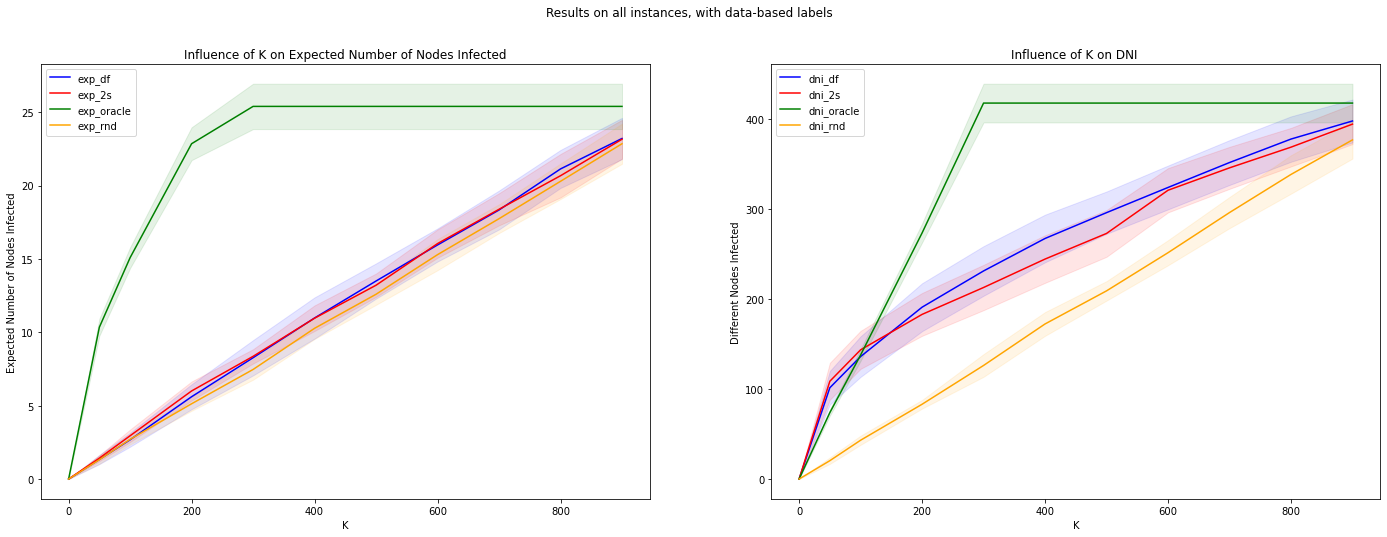

In [ ]:
df_results_all['exp_df_lower'] = df_results_all['exp_df'] - df_results_all['exp_df_std']
df_results_all['exp_df_upper'] = df_results_all['exp_df'] + df_results_all['exp_df_std']
df_results_all['exp_2s_lower'] = df_results_all['exp_2s'] - df_results_all['exp_2s_std']
df_results_all['exp_2s_upper'] = df_results_all['exp_2s'] + df_results_all['exp_2s_std']
df_results_all['exp_oracle_lower'] = df_results_all['exp_oracle'] - df_results_all['exp_oracle_std']
df_results_all['exp_oracle_upper'] = df_results_all['exp_oracle'] + df_results_all['exp_oracle_std']
df_results_all['exp_rnd_lower'] = df_results_all['exp_rnd'] - df_results_all['exp_rnd_std']
df_results_all['exp_rnd_upper'] = df_results_all['exp_rnd'] + df_results_all['exp_rnd_std']

df_results_all['dni_df_lower'] = df_results_all['dni_df'] - df_results_all['dni_df_std']
df_results_all['dni_df_upper'] = df_results_all['dni_df'] + df_results_all['dni_df_std']
df_results_all['dni_2s_lower'] = df_results_all['dni_2s'] - df_results_all['dni_2s_std']
df_results_all['dni_2s_upper'] = df_results_all['dni_2s'] + df_results_all['dni_2s_std']
df_results_all['dni_oracle_lower'] = df_results_all['dni_oracle'] - df_results_all['dni_oracle_std']
df_results_all['dni_oracle_upper'] = df_results_all['dni_oracle'] + df_results_all['dni_oracle_std']
df_results_all['dni_rnd_lower'] = df_results_all['dni_rnd'] - df_results_all['dni_rnd_std']
df_results_all['dni_rnd_upper'] = df_results_all['dni_rnd'] + df_results_all['dni_rnd_std']

def plot_kdependence_all(df_results_all, title=""):
    """
    d_results : exp_df, dni_df, exp_2s, dni_2s, exp_oracle, dni_oracle, exp_rnd, dni_rnd
    """
    fig,ax = plt.subplots(1,2,figsize=(24,8))
    sns.lineplot(data=df_results_all, x=df_results_all.index, y='exp_df', label='exp_df', color='blue', ax=ax[0])
    sns.lineplot(data=df_results_all, x=df_results_all.index, y='exp_2s', label='exp_2s', color='red', ax=ax[0])
    sns.lineplot(data=df_results_all, x=df_results_all.index, y='exp_oracle', label='exp_oracle', color='green', ax=ax[0])
    sns.lineplot(data=df_results_all, x=df_results_all.index, y='exp_rnd', label='exp_rnd', color='orange', ax=ax[0])
    
    ax[0].fill_between(df_results_all.index, df_results_all['exp_df_lower'], df_results_all['exp_df_upper'], color='blue', alpha=0.1)
    ax[0].fill_between(df_results_all.index, df_results_all['exp_2s_lower'], df_results_all['exp_2s_upper'], color='red', alpha=0.1)
    ax[0].fill_between(df_results_all.index, df_results_all['exp_oracle_lower'], df_results_all['exp_oracle_upper'], color='green', alpha=0.1)
    ax[0].fill_between(df_results_all.index, df_results_all['exp_rnd_lower'], df_results_all['exp_rnd_upper'], color='orange', alpha=0.1)

    ax[0].set_title('Influence of K on Expected Number of Nodes Infected')
    ax[0].set_xlabel('K')
    ax[0].set_ylabel('Expected Number of Nodes Infected')
    ax[0].legend()

    sns.lineplot(data=df_results_all, x=df_results_all.index, y='dni_df', label='dni_df', color='blue', ax=ax[1])
    sns.lineplot(data=df_results_all, x=df_results_all.index, y='dni_2s', label='dni_2s', color='red', ax=ax[1])
    sns.lineplot(data=df_results_all, x=df_results_all.index, y='dni_oracle', label='dni_oracle', color='green', ax=ax[1])
    sns.lineplot(data=df_results_all, x=df_results_all.index, y='dni_rnd', label='dni_rnd', color='orange', ax=ax[1])

    ax[1].fill_between(df_results_all.index, df_results_all['dni_df_lower'], df_results_all['dni_df_upper'], color='blue', alpha=0.1)
    ax[1].fill_between(df_results_all.index, df_results_all['dni_2s_lower'], df_results_all['dni_2s_upper'], color='red', alpha=0.1)
    ax[1].fill_between(df_results_all.index, df_results_all['dni_oracle_lower'], df_results_all['dni_oracle_upper'], color='green', alpha=0.1)
    ax[1].fill_between(df_results_all.index, df_results_all['dni_rnd_lower'], df_results_all['dni_rnd_upper'], color='orange', alpha=0.1)

    ax[1].set_title('Influence of K on DNI ')
    ax[1].set_xlabel('K')
    ax[1].set_ylabel('Different Nodes Infected')
    ax[1].legend()

    fig.suptitle(title)
    plt.show()

plot_kdependence_all(df_results_all, title="Results on all instances, with data-based labels")